In [1]:
!pip install "zarr<3" -U

## Convertion sbasic.dat into xarray

In [3]:
from functoolz_bin import *

im: int = 902
jm: int = 650 
km: int = 47
print(im)
ds_sbasic, fildsc, ichflg = read_basic_to_xarray("/mnt/c/Users/ecap/Documents/JCOPE/sbasic/sbasic.dat",im=im,jm=jm,km=km,)

ds_sbasic.chunk({"longitude":902/2,"latitude":650/2,"zlev":"10M"}).to_zarr('jcope.zarr',mode='w')
ds_sbasic

902
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


<xarray.Dataset> Size: 661MB
Dimensions:    (latitude: 650, longitude: 902, z: 47, zlev: 47)
Coordinates:
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * z          (z) int32 188B 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47
  * zlev       (zlev) float64 376B -2.5 -7.5 -12.5 ... -1.45e+03 -1.55e+03
Data variables:
    Z          (latitude, longitude, z) float64 220MB 0.0 -2.0 ... -5.803e+03
    ZZ         (latitude, longitude, z) float64 220MB -1.0 -3.5 ... -5.803e+03
    DZ         (latitude, longitude, z) float64 220MB 2.0 3.0 ... 269.0 269.0
Attributes: (12/13)
    title:                basic.dat (Z, ZZ, DZ) from a Fortran unformatted se...
    fortran_unformatted:  sequential
    endianness:           big-or-little (auto-detected)
    record_marker_bytes:  4
    fildsc:               runz
    im:                   902
    ...                   ...
    km:                   47
    dx:                   0.027777777777777776
    dy:                   0.027777777777777776
    xlons:                119.986111
    ylats:                16.986111
    ichflg_expected:      123456

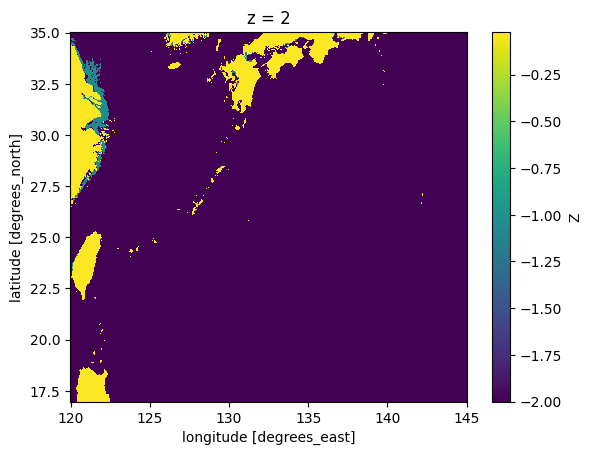

In [4]:
ds_sbasic.Z.isel(z=1).plot()

Now we have converted the sbasic into xarray.dataset we have Z , ZZ (layers thickness), DZ 

zlev(kzd) →  layer centers

z_z(kzd+1) → depths of the interfaces.

dz_z(kzd) → vertical thickness of layers.

## Now we need to convert some binaries files in order to get them as xarray

In [5]:
from download_bin import fetch_hourly_and_decompress


output_base_dir = Path("/mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/")

# URL du dossier distant 
base_url = "https://www.jamstec.go.jp/jcope/data/odaka20240424-2102"

# Date de départ 
start_time = "202102220000"
n_time = 2
# overwrite=False évite de retélécharger / regunzipper si déjà présent
overwrite_downloads = False

# strict=True lèvera une erreur si on n'a pas trouvé exactement n_time fichiers
strict_mode = True
# ---------------------------------------------------------

egtdir_new = output_base_dir / "EGT"
ttdir_new  = output_base_dir / "TT"

fetch_hourly_and_decompress("EGT", base_url, start_time, n_time, egtdir_new,
                            overwrite=overwrite_downloads, strict=strict_mode)
fetch_hourly_and_decompress("TT",  base_url, start_time, n_time, ttdir_new,
                            overwrite=overwrite_downloads, strict=strict_mode)

egtdir = egtdir_new
ttdir  = ttdir_new

[DEBUG] checking /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/EGT/EGT_202102220000.bin (overwrite=False)
-> EGT_202102220000.bin exists, SKIP (no touch to EGT_202102220000.bin.gz)
[DEBUG] checking /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/EGT/EGT_202102220100.bin (overwrite=False)
-> EGT_202102220100.bin exists, SKIP (no touch to EGT_202102220100.bin.gz)
[OK] 2 fichiers .bin prêts dans /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/EGT
[DEBUG] checking /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT/TT_202102220000.bin (overwrite=False)
-> TT_202102220000.bin exists, SKIP (no touch to TT_202102220000.bin.gz)
[DEBUG] checking /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT/TT_202102220100.bin (overwrite=False)
-> TT_202102220100.bin exists, SKIP (no touch to TT_202102220100.bin.gz)
[OK] 2 fichiers .bin prêts dans /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT


In [6]:
from pathlib import Path
import numpy as np
import xarray as xr

egt_ctl = egtdir.parent / "CTL/EGT_patch_zdef1.ctl"


tt_ctl = ttdir.parent / "CTL/TT.ctl"

out_path = ttdir / "EGT_TT.zarr"

In [8]:
# -------------------

# Lire les n premiers pas de temps 
ds_egt = read_first_n_times(egtdir, egt_ctl, "EGT_*.bin", n=n_time)
ds_tt  = read_first_n_times(ttdir, tt_ctl, "TT_*.bin", n=n_time)

ds_combined_ssh_tt = xr.merge([ds_egt, ds_tt])
ds_combined_ssh_tt = ds_combined_ssh_tt.rename({"x": "longitude", "y": "latitude", "sigma": "z"})

Reading EGT_202102220000.bin
Reading EGT_202102220100.bin
Reading TT_202102220000.bin
Reading TT_202102220100.bin


In [12]:
ds_combined_ssh_tt = ds_combined_ssh_tt.chunk({"time": 1, "latitude": -1, "longitude": -1,"z":-1})

In [15]:
out_path

PosixPath('/mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT/EGT_TT.zarr')

In [13]:
ds_combined_ssh_tt.to_zarr(out_path,mode='w')

In [17]:
import xarray as xr
ds_combined_ssh_tt = xr.open_dataset(out_path)
ds_combined_ssh_tt

<xarray.Dataset> Size: 225MB
Dimensions:    (time: 2, latitude: 650, longitude: 902, z: 47)
Coordinates:
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * time       (time) datetime64[ns] 16B 2021-02-22 2021-02-22T01:00:00
  * z          (z) float32 188B 1.0 2.0 3.0 4.0 5.0 ... 43.0 44.0 45.0 46.0 47.0
Data variables:
    el         (time, latitude, longitude) float32 5MB ...
    t          (time, z, latitude, longitude) float32 220MB ...
Attributes:
    history:  time coordinate set from filename
    title:    el first 2 times concatenated from GrADS binaries

In [ ]:
# Écriture
print(f"Ecriture du NetCDF : {out_path}")
ds_combined_ssh_tt.to_zarr(out_path,mode='w')
print("[OK] Fichier écrit :", out_path)
ds_combined_ssh_tt

Reading EGT_202102220000.bin
Reading EGT_202102220100.bin
Reading TT_202102220000.bin
Reading TT_202102220100.bin
Ecriture du NetCDF : /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT/EGT_TT.zarr
[OK] Fichier écrit : /mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT/EGT_TT.zarr


<xarray.Dataset> Size: 225MB
Dimensions:    (latitude: 650, longitude: 902, time: 2, z: 47)
Coordinates:
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * time       (time) datetime64[ns] 16B 2021-02-22 2021-02-22T01:00:00
  * z          (z) float32 188B 1.0 2.0 3.0 4.0 5.0 ... 43.0 44.0 45.0 46.0 47.0
Data variables:
    el         (time, latitude, longitude) float32 5MB 0.2286 0.2305 ... 1.014
    t          (time, z, latitude, longitude) float32 220MB 26.25 26.23 ... nan
Attributes:
    title:    el first 2 times concatenated from GrADS binaries
    history:  time coordinate set from filename

In [14]:
import xarray as xr
ds_combined_ssh_tt = xr.open_dataset('/mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT/EGT_TT.zarr')
ds_combined_ssh_tt

/home/ecap/micromamba/envs/pangeo-fish_debug/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


<xarray.Dataset> Size: 225MB
Dimensions:    (time: 2, latitude: 650, longitude: 902, z: 47)
Coordinates:
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * time       (time) datetime64[ns] 16B 2021-02-22 2021-02-22T01:00:00
  * z          (z) float32 188B 1.0 2.0 3.0 4.0 5.0 ... 43.0 44.0 45.0 46.0 47.0
Data variables:
    el         (time, latitude, longitude) float32 5MB ...
    t          (time, z, latitude, longitude) float32 220MB ...
Attributes:
    history:  time coordinate set from filename
    title:    el first 2 times concatenated from GrADS binaries

In [ ]:
ds_combined_ssh_tt.el.isel(time=0).plot()

Here **I spot a problem** there is a very small diff between both lon/lat 

Trick to avoid the differences between both latitudes/longitudes 

In [ ]:
ds_sbasic = ds_sbasic.assign_coords(
    longitude = ("longitude", ds_combined_ssh_tt.longitude.values),
    latitude  = ("latitude",  ds_combined_ssh_tt.latitude.values)
)
ds_sbasic

Now that we have converted :

1. **sbasic.dat** to xarray ( z, zz, dz)
2. **binary conversion** , for some timesteps, from EGT_XXXXXXX ( --> SSH ) and TT_XXXXXXX ( ocean temperature by layers)

Now the purpose is to get from sigma coordinate (cf ds_combined_ssh_tt above using sigma) to depth in meters so we'll need :
1. Merge both xarray
2. interpolate the informations of the layer using sigma coordinate (Z , and ZZ) to finish with a "depth" coordinate in meters.   

In [ ]:
#ds_combined_ssh_tt = ds_combined_ssh_tt.rename({"x": "longitude", "y": "latitude", "sigma": "z"}).assign_coords(z=lambda ds: ds["z"].astype(int))
#ds_merged = ds_sbasic.merge(ds_combined_ssh_tt.drop_vars(["longitude", "latitude"]))
ds_merged = ds_sbasic.merge(ds_combined_ssh_tt)
ds_merged

In [ ]:
ds_merged.ZZ.isel(z=25).plot()

## Now we have merge the dataset with all the values that we gonna need we can interpolate the infos

In [ ]:
ds_from_bin = ds_merged

In [ ]:
from pathlib import Path
import requests
import xarray as xr

url = "https://www.jamstec.go.jp/jcope/data/odaka20240424-netcdf/TT_20210222.nc"
local = Path("/mnt/c/Users/ecap/Documents/JCOPE/TT_20210222.nc")

local.parent.mkdir(parents=True, exist_ok=True)


if not local.exists():
    print(f"Téléchargement {url} → {local}")
    r = requests.get(url)
    r.raise_for_status()
    with open(local, "wb") as f:
        f.write(r.content)
else:
    print(f"Fichier déjà présent : {local}")


ds_netcdf_reference = xr.open_dataset(local)
ds_netcdf_reference

In [ ]:
import time

time_vals = ds_from_bin['time'].values
depth_target_pos = -ds_netcdf_reference.depth.values
# depth_target_pos = array([  0.,   5.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
#        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 225., 250.,
#        275., 300., 350., 400., 450., 500.], dtype=float32)
# depth_target_pos = -np.arange(0,2001,50)
# depth_target_pos = -np.linspace(0, 2000, 47, dtype=np.float32)
ny = ds_from_bin.dims['latitude']
nx = ds_from_bin.dims['longitude']
nt = ds_from_bin.dims['time']
nz_out = len(depth_target_pos)


nt_proc = min(97, nt)
print(f"[INFO] nt total = {nt}, nt_proc = {nt_proc}")

# Préallocation sur nt_proc (beaucoup plus petit que nt)
TLEV_all = np.full((nt_proc, ny, nx, nz_out), np.nan, dtype=np.float32)

total_start = time.time()
for it in range(nt_proc):
    step_start = time.time()
    print(f"[INFO] Début interpolation time step {it+1}/{nt_proc} (global step {it+1}/{nt})")
    
    # récupérer le champ t; on suppose shape (z, lat, lon) après isel(time=it)
    T0_t = ds_from_bin['t'].isel(time=it).values   # (z, lat, lon)
    T0_t = np.transpose(T0_t, (1, 2, 0))             # (lat, lon, z)

    # selecting with ssh or not 
    ssh = ds_from_bin['el'].isel(time=it).values   # shape (lat, lon)
    # ssh = np.zeros((ny, nx), dtype=np.float32)
    
    TLEV_all[it] = interp_sigma_to_zlev_with_ssh_numba(
                                                T=T0_t,
                                                Z=None,                 # on ignore Z
                                                ZZ=ds_from_bin['ZZ'].values,
                                                ssh=ssh,
                                                zlev=depth_target_pos,  # tes profondeurs cibles
                                                grid_h=0,
                                                grid_z=0,               
                                                min_depth=1e-3
                                                )
    
    step_elapsed = time.time() - step_start
    total_elapsed_so_far = time.time() - total_start
    avg_per_step = total_elapsed_so_far / (it + 1)
    remaining_est = avg_per_step * (nt_proc - (it + 1))
    
    print(f"[INFO] Fin time step {it+1}/{nt_proc} en {step_elapsed:.2f} s — "
          f"cumul {total_elapsed_so_far:.2f} s — estimé restant {remaining_est:.2f} s")

total_elapsed = time.time() - total_start
print(f"[INFO] Traitement des {nt_proc} pas terminé en {total_elapsed:.2f} s")

# Conversion en xarray pour les nt_proc premiers pas
da = xr.DataArray(
    TLEV_all,
    dims=('time','latitude','longitude','depth'),
    coords={
        'time': time_vals[:nt_proc],
        'latitude': ds_from_bin.latitude.values,
        'longitude': ds_from_bin.longitude.values,
        'depth': -depth_target_pos
    },
    name='t_on_depth'
)
ds_out = da.to_dataset(name='t_on_depth')
ds_out

In [ ]:
ds_out.t_on_depth.isel(time=50,depth=27).plot()

In [ ]:
ds_out.to_zarr("/mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/model_interp_4day_2000mdepth.zarr")

In [ ]:
import xarray as xr
ds_out= xr.open_zarr("/mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/model_interp_4day_2000mdepth.zarr")
ds_netcdf_reference= xr.open_dataset("/mnt/c/Users/ecap/Documents/JCOPE/TT_20210222.nc")

In [ ]:
ds_reduit_netcdf_great = ds_netcdf_reference.sel(
    lat=slice(20, 34),
    lon=slice(125, 140)
)
ds_out_reduit = ds_out.sel(
    latitude=slice(20, 34),
    longitude=slice(125, 140)
)

In [ ]:
display(ds_reduit_netcdf_great,ds_out_reduit)

In [ ]:
ds2 = ds_out_reduit.rename({'latitude': 'lat', 'longitude': 'lon'})
ds1 = ds_reduit_netcdf_great
ds1_common = ds1.sel(time=slice("2021-02-22", "2021-02-22"))
ds2_common = ds2.sel(time=slice("2021-02-22", "2021-02-22"))

ds2_common


In [ ]:
diff = ds1_common['TT'] - ds2_common['t_on_depth'].drop_vars(["lon", "lat"])

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
# === Fonction d’affichage ===
def plot_diff(time_index=0, depth=50):
    plt.clf()  # nettoie la figure avant d'afficher
    fig, ax = plt.subplots(figsize=(8,6))
    diff.sel(time=diff.time[time_index], depth=depth).plot(
        cmap="coolwarm", robust=True, ax=ax
    )
    ax.set_title(f"Différence TT - t_on_depth\n{str(diff.time[time_index].values)} | {depth} m")
    plt.show()

# Widgets interactifs
interact(
    plot_diff,
    time_index=widgets.IntSlider(min=0, max=len(diff.time)-1, step=1, value=0),
    depth=widgets.IntSlider(min=0, max=int(diff.depth.max()), step=25, value=50)
)


# convert sigma to depth

In [ ]:
import cf_xarray  # noqa: F401
import numpy as np


def marc_sigma_to_depth(model):
    s = model.cf["ocean_s_coordinate"]
    eta = model.cf["sea_surface_height_above_sea_level"]
    depth = model.cf["model_sea_floor_depth_below_sea_level"]
    a = model.cf["ocean_s_coordinate_surface_control"]
    b = model.cf["ocean_s_coordinate_bottom_control"]
    depth_c = model.cf["ocean_s_coordinate_thick_of_surface_resolution"]

    C = (1.0 - b) * np.sinh(a * s) / np.sinh(a) + b * (
        np.tanh(a * (s + 0.5)) - np.tanh(0.5 * a)
    ) / (2.0 * np.tanh(0.5 * a))

    z = (eta * (1.0 + s) + depth_c * s + (depth - depth_c) * C).astype("float32")

    depth_ = (z + eta).assign_attrs({"units": "m"})
    bottom = (eta + depth).assign_attrs({"units": "m"})

    return model.assign(depth=depth_, bottom=bottom)[["TEMP", "depth", "bottom", "H0"]]

In [ ]:
import xarray as xr

def dsigma_to_depth(ds: xr.Dataset) -> xr.Dataset:
    # profondeur des centres de couches
    depth_ = (ds["ZZ"].expand_dims(time=ds.time) + ds["el"]).transpose("time", "z", "latitude", "longitude")
    depth_ = depth_.assign_attrs({"units": "m", "long_name": "Depth at layer centers"})

    return ds.assign(depth=depth_)[["t", "depth", "el"]]


In [ ]:
ds_combined_ssh_tt = xr.open_dataset('/mnt/c/Users/ecap/Documents/JCOPE/4days_data_jcope_202102/TT/EGT_TT.zarr')

ds_sbasic = ds_sbasic.assign_coords(
    longitude = ("longitude", ds_combined_ssh_tt.longitude.values),
    latitude  = ("latitude",  ds_combined_ssh_tt.latitude.values)
)

ds_merged = ds_sbasic.merge(ds_combined_ssh_tt)
ds_merged

In [ ]:
mix_res = dsigma_to_depth(ds_merged)

In [ ]:
mix_res.depth.isel(time=0,z=0).plot()

In [ ]:
mix_res

In [ ]:
mix_res.depth.isel(time=0,z=35).plot()

In [ ]:
import numpy as np
import xarray as xr

def compute_mean_diff_field(ds, tag_temp, tag_depth, depth_thresh=0.0):
    """
    ds : xarray.Dataset contenant ds['t'] and ds['depth']
         shapes: t(depth) -> (time, z, latitude, longitude)
                 depth -> (time, z, latitude, longitude)  (Z + ssh)
    tag_temp, tag_depth : 1D numpy arrays (len = n_o) ; tag_depth en m (positif vers le bas)
    depth_thresh : non utilisé ici mais gardé pour compatibilité
    Retour : xarray.DataArray (time, latitude, longitude) de la moyenne (tag_temp - model_temp_nearest)
    """
    model_t = ds['t'].values.astype(np.float32)       # shape (T, Z, Y, X)
    model_depth = ds['depth'].values.astype(np.float32)
    # si profondeur négative, rendre positive (convention)
    if np.nanmax(model_depth) <= 0:
        model_depth = np.abs(model_depth)

    T, Z, Y, X = model_depth.shape
    o = int(np.asarray(tag_depth).size)

    # masque niveaux valides (pas NaN ni pour depth ni temp)
    valid_lvl = (~np.isnan(model_depth)) & (~np.isnan(model_t))  # shape (T,Z,Y,X)
    any_valid = valid_lvl.any(axis=1)  # (T,Y,X) => indique s'il y a au moins un niveau valide

    # accumulateurs pour moyenne (on évite de garder tous les diffs)
    sum_diff = np.zeros((T, Y, X), dtype=np.float64)
    count = np.zeros((T, Y, X), dtype=np.int32)

    for j in range(o):
        td = float(tag_depth[j])
        tt = float(tag_temp[j])
        if np.isnan(td) or np.isnan(tt):
            continue

        # distance absolue en profondeur ; où pas valide on met +inf pour ne pas choisir
        # absdiff shape => (T, Z, Y, X)
        absdiff = np.where(valid_lvl, np.abs(model_depth - td), np.inf)

        # index de la couche modèle la plus proche le long de l'axe Z
        idx = np.argmin(absdiff, axis=1)  # shape (T, Y, X)

        # récupérer la température modèle au layer trouvé :
        # on étend idx pour axis=1 et utilise take_along_axis
        idx_exp = idx[:, None, :, :]  # (T,1,Y,X)
        temp_at = np.take_along_axis(model_t, idx_exp, axis=1).squeeze(axis=1)  # (T,Y,X)

        # si pour un point il n'y a aucun niveau valide, on force NaN
        temp_at[~any_valid] = np.nan

        # différence pour cet observation j
        diff_j = tt - temp_at   # (T,Y,X), NaN là où temp_at est NaN

        # mettre à jour somme et compte en ignorant NaN
        mask_valid = ~np.isnan(diff_j)
        sum_diff[mask_valid] += diff_j[mask_valid]
        count[mask_valid] += 1

    # moyenne (éviter division par zéro)
    mean_diff = np.full((T, Y, X), np.nan, dtype=np.float32)
    nonzero = count > 0
    mean_diff[nonzero] = (sum_diff[nonzero] / count[nonzero]).astype(np.float32)

    # reconstruire DataArray xarray
    da = xr.DataArray(
        mean_diff,
        coords={'time': ds['time'].values,
                'latitude': ds['latitude'].values,
                'longitude': ds['longitude'].values},
        dims=('time', 'latitude', 'longitude')
    )

    return da


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


ds_small = mix_res.isel(time=slice(0, 3), latitude=slice(0, 150), longitude=slice(0, 150))

tag_depth = np.array([3.5, 10.2, 25.0, 40.0], dtype=np.float32)
tag_temp  = np.array([27.1, 25.3, 20.8, 15.2], dtype=np.float32)


ds_small.el.isel(time=0).plot()

In [ ]:


# ---------- 4) exécution ----------
mean_diff_da = compute_mean_diff_field(ds_small, tag_temp, tag_depth)
print("Résultat mean_diff_da :", mean_diff_da.shape)
print("Stats (mean/min/max) sur tous les points (ignoring NaN):",
      float(np.nanmean(mean_diff_da.values)),
      float(np.nanmin(mean_diff_da.values)),
      float(np.nanmax(mean_diff_da.values)))

# nombre de points non-NaN par pas de temps
valid_counts = (~np.isnan(mean_diff_da.values)).sum(axis=(1,2))
print("Nombre de points valides par time step:", valid_counts)

# ---------- 5) inspection rapide d'une grille (time=0) ----------
t0 = 0
da0 = mean_diff_da.isel(time=t0)
plt.figure(figsize=(6,4))
im = plt.pcolormesh(da0.longitude, da0.latitude, da0.values, shading='auto')
plt.colorbar(im, label='tag_temp - model_temp (°C)')
plt.title(f'mean diff time index {t0}')
plt.xlabel('longitude'); plt.ylabel('latitude')
plt.tight_layout()
plt.show()

# ---------- 6) debug : afficher un exemplaire model_depth/model_temp pour comprendre ----------
iy = 0; ix = 0; it = 0  # indices d'exemple
print("Exemple model depths (z) pour time,lat,lon =", it, iy, ix)
print(ds_small['depth'].isel(time=it, latitude=iy, longitude=ix).values)
print("Exemple model temps (z) :")
print(ds_small['t'].isel(time=it, latitude=iy, longitude=ix).values)

# On test FUNCTION DE BASE

In [ ]:
"""Implements diff operations between tags and reference data."""

import numba
import numpy as np
import xarray as xr

_diff_z_signatures = [
    "void(float32[:], float32[:], float32, float32[:], float32[:], float32, float32[:])",
    "void(float64[:], float64[:], float64, float64[:], float64[:], float32, float64[:])",
    "void(float32[:], float32[:], float32, float64[:], float64[:], float32, float64[:])",
    "void(float64[:], float64[:], float64, float32[:], float32[:], float32, float64[:])",
]


@numba.guvectorize(_diff_z_signatures, "(z),(z),(),(o),(o),()->()", nopython=True)
def _diff_z(model_temp, model_depth, tag_temp, tag_depth, depth_thresh, result):
    # if depth_thresh != 0 and bottom < np.max(tag_depth) * depth_thresh:
    #     result[0] = np.nan
    #     return

    diff_temp = np.full_like(tag_depth, fill_value=np.nan)
    mask = ~np.isnan(model_depth) & ~np.isnan(model_temp)
    model_depth_ = np.absolute(model_depth[mask])
    if model_depth_.size == 0:
        result[0] = np.nan
        return

    model_temp_ = model_temp[mask]

    for index in range(tag_depth.shape[0]):
        if not np.isnan(tag_depth[index]):
            diff_depth = np.absolute(model_depth_ - tag_depth[index])

            idx = np.argmin(diff_depth)

            diff_temp[index] = tag_temp[index] - np.absolute(model_temp_[idx])

    result[0] = np.mean(diff_temp[~np.isnan(diff_temp)])


def diff_z_numba(model_temp, model_depth, tag_temp, tag_depth):
    with np.errstate(all="ignore"):
        # TODO: figure out why the "invalid value encountered" warning is raised
        return _diff_z(
            model_temp, model_depth, tag_temp, tag_depth
        )


def diff_z(model, tag, depth_threshold=0.8):
    diff = xr.apply_ufunc(
        diff_z_numba,
        model["TEMP"],
        model["dynamic_depth"],
        tag["temperature"],
        tag["pressure"],
        input_core_dims=[["depth"], ["depth"], [], ["obs"], ["obs"]],
        output_core_dims=[[]],
        exclude_dims={},
        vectorize=False,
        dask="parallelized",
        output_dtypes=[model.dtypes["TEMP"]],
    )
    original_units = model["TEMP"].attrs["units"]

    return diff.assign_attrs({"units": original_units}).to_dataset(name="diff")


In [ ]:
model = xr.Dataset()

# TEMP : la variable température du modèle
model["TEMP"] = mix_res["t"].astype(np.float32)
model["TEMP"].attrs = mix_res["t"].attrs if "t" in mix_res else {"units": "degC"}

# dynamic_depth : profondeur des centres de couches (time,z,lat,lon)
# ASSUMPTION : mix_res['depth'] est déjà Z + ssh (comme tu l'avais)
# On force convention profondeur positive (valeurs > 0 vers le bas)
dynamic_depth = np.abs(mix_res["depth"].astype(np.float32))
model["dynamic_depth"] = dynamic_depth

# dynamic_bathymetry : estimation de la profondeur du fond (m positif)
# Choix simple : prendre la profondeur maximale absolue le long de z (devrait approximer le fond).
# Cela donne un array (time, latitude, longitude)
dynamic_bathymetry = np.nanmax(np.abs(mix_res["depth"].values), axis=1)  # axis z -> shape (time,lat,lon)
# remettre en DataArray avec mêmes coords
dynamic_bathymetry = xr.DataArray(
    dynamic_bathymetry,
    coords={"time": mix_res["time"].values,
            "latitude": mix_res["latitude"].values,
            "longitude": mix_res["longitude"].values},
    dims=("time", "latitude", "longitude"),
)
model["dynamic_bathymetry"] = dynamic_bathymetry.astype(np.float32)



In [ ]:
import numpy as np
o_tag = np.array([3.5, 10.2, 25.0, 40.0], dtype=np.float32)     # profondeurs observées (m)
t_tag = np.array([27.1, 25.3, 20.8, 15.2], dtype=np.float32)    # températures correspondantes

tag = xr.Dataset({
    "temperature": xr.DataArray(t_tag, coords={"obs": np.arange(t_tag.size)}, dims=("obs",)),
    "pressure": xr.DataArray(o_tag, coords={"obs": np.arange(o_tag.size)}, dims=("obs",)),
})
# NOTE: dans ton code original 'pressure' est le nom attendu pour tag depth ; 
# si tu veux appeler ça 'depth' adapte diff_z_apply en conséquence.

# --- 2C : appeler la fonction (compilation numba se fera à la première exécution) ---
depth_threshold = 0.8  # réglage par défaut
diff_ds = diff_z_apply(model, tag, depth_threshold=depth_threshold)

# --- 2D : affichages / vérifications simples ---
print(diff_ds)
print("résumé (ignorer NaN) : mean/min/max =",
      float(np.nanmean(diff_ds["diff"].values)),
      float(np.nanmin(diff_ds["diff"].values)),
      float(np.nanmax(diff_ds["diff"].values)))

# afficher un extrait pour time=0
print("diff time=0 shape:", diff_ds["diff"].isel(time=0).shape)